### Time Series Merge & Append

### FTP Connection

Connection parameters

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

In [2]:
# The topic of interest.
topic_dir = "/hourly/precipitation/historical/"
#topic_dir = "/annual/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

Local Directories

In [3]:
local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallelly merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD//hourly/precipitation/historical/
../data/original/DWD//hourly/precipitation/historical/

../data/generated/DWD/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/


In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

FTP Connect

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
ret = ftp.cwd(".")

In [8]:
#ftp.quit()

FTP Grab File Function

In [9]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")

Generate Pandas Dataframe from FTP Directory Listing

In [10]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [11]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [12]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_hourly_precipi...,.pdf,71445,-
1,-1,DESCRIPTION_obsgermany_climate_hourly_precipit...,.pdf,69716,-
2,-1,RR_Stundenwerte_Beschreibung_Stationen.txt,.txt,209079,-
3,3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419265,-
4,20,stundenwerte_RR_00020_20040814_20191231_hist.zip,.zip,407378,-
5,44,stundenwerte_RR_00044_20070401_20191231_hist.zip,.zip,320516,-
6,53,stundenwerte_RR_00053_20051001_20191231_hist.zip,.zip,361931,-
7,71,stundenwerte_RR_00071_20041022_20191231_hist.zip,.zip,402880,-
8,73,stundenwerte_RR_00073_20070401_20191231_hist.zip,.zip,333070,-
9,78,stundenwerte_RR_00078_20041101_20191231_hist.zip,.zip,384729,-


 Dataframe with TS Zip Files

In [13]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419265,-
20,stundenwerte_RR_00020_20040814_20191231_hist.zip,.zip,407378,-
44,stundenwerte_RR_00044_20070401_20191231_hist.zip,.zip,320516,-
53,stundenwerte_RR_00053_20051001_20191231_hist.zip,.zip,361931,-
71,stundenwerte_RR_00071_20041022_20191231_hist.zip,.zip,402880,-
73,stundenwerte_RR_00073_20070401_20191231_hist.zip,.zip,333070,-
78,stundenwerte_RR_00078_20041101_20191231_hist.zip,.zip,384729,-
87,stundenwerte_RR_00087_20050201_20191231_hist.zip,.zip,379869,-
91,stundenwerte_RR_00091_20040901_20191231_hist.zip,.zip,394972,-


 Download the Station Description File

In [14]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

RR_Stundenwerte_Beschreibung_Stationen.txt


In [15]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   ../data/original/DWD//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt


In [16]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [17]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2021-02-23,432,48.9220,9.9129,Abtsgmьnd-Untergrцningen,Baden-Wьrttemberg
44,2007-04-01,2021-02-23,44,52.9336,8.2370,GroЯenkneten,Niedersachsen
53,2005-10-01,2021-02-23,60,52.5850,13.5634,Ahrensfelde,Brandenburg
71,2004-10-22,2020-01-01,759,48.2156,8.9784,Albstadt-Badkap,Baden-Wьrttemberg


Select Stations Located in NRW from Station Description Dataframe

In [18]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,   216,   326,   389,   390,   554,   555,   599,   603,
              613,   617,   644,   796,   871,   902,   934,   989,  1024,
             1046,  1078,  1241,  1246,  1300,  1303,  1327,  1590,  1595,
             1766,  2027,  2110,  2254,  2473,  2483,  2497,  2629,  2667,
             2703,  2810,  2947,  2968,  2999,  3028,  3031,  3081,  3098,
             3215,  3321,  3339,  3499,  3540,  3591,  3795,  3913,  4063,
             4127,  4150,  4154,  4313,  4368,  4371,  4400,  4488,  4692,
             4741,  4849,  5064,  5347,  5360,  5468,  5480,  5513,  5619,
             5699,  5717,  5719,  5733,  6197,  6264,  6276,  6313,  6337,
             7106,  7330,  7344,  7374,  7378, 13669, 13670, 13671, 13696,
            13700, 13713, 15000],
           dtype='int64', name='station_id')

In [19]:
# Create variable with TRUE if state is Nordrhein-Westfalen

# isNRW = df_stations['state'] == "Nordrhein-Westfalen"
isNRW = df_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

#isBefore1950 = df_stations['date_from'] < '1950'
#dfNRW = df_stations[isNRW & isOperational & isBefore1950]

# select on both conditions

dfNRW = df_stations[isNRW & isOperational]

#print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
216,2004-10-01,2021-02-23,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
389,2009-11-01,2021-02-23,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
390,2004-07-01,2021-02-23,610,50.9837,8.3683,"Berleburg, Bad-Stьnzel",Nordrhein-Westfalen
554,1995-09-01,2021-02-23,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
603,1999-03-03,2021-02-23,147,50.7293,7.2040,Kцnigswinter-Heiderhof,Nordrhein-Westfalen
...,...,...,...,...,...,...,...
13671,2007-12-01,2021-02-23,221,50.9655,7.2753,Overath-Bцke,Nordrhein-Westfalen
13696,2007-12-01,2021-02-23,60,51.5966,7.4048,Waltrop-Abdinghof,Nordrhein-Westfalen
13700,2008-05-01,2021-02-23,205,51.3329,7.3411,Gevelsberg-Oberbrцking,Nordrhein-Westfalen


In [20]:
print(df_zips)

                                                        name   ext    size  \
station_id                                                                   
3           stundenwerte_RR_00003_19950901_20110401_hist.zip  .zip  419265   
20          stundenwerte_RR_00020_20040814_20191231_hist.zip  .zip  407378   
44          stundenwerte_RR_00044_20070401_20191231_hist.zip  .zip  320516   
53          stundenwerte_RR_00053_20051001_20191231_hist.zip  .zip  361931   
71          stundenwerte_RR_00071_20041022_20191231_hist.zip  .zip  402880   
...                                                      ...   ...     ...   
15478       stundenwerte_RR_15478_20150201_20191231_hist.zip  .zip  126658   
15490       stundenwerte_RR_15490_20161201_20191231_hist.zip  .zip   81166   
15512       stundenwerte_RR_15512_20160901_20191231_hist.zip  .zip   83934   
15514       stundenwerte_RR_15514_20171101_20191231_hist.zip  .zip   56846   
15555       stundenwerte_RR_15555_20160501_20191231_hist.zip  .z

Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations which are TS data provided for (zip files) do not match perfectly. 

In [21]:
list(dfNRW.index)

[216,
 389,
 390,
 554,
 603,
 613,
 617,
 644,
 796,
 871,
 902,
 934,
 989,
 1024,
 1046,
 1078,
 1241,
 1246,
 1300,
 1303,
 1327,
 1590,
 1595,
 1766,
 2027,
 2110,
 2254,
 2473,
 2483,
 2497,
 2629,
 2667,
 2810,
 2947,
 2968,
 2999,
 3028,
 3031,
 3081,
 3098,
 3215,
 3321,
 3339,
 3499,
 3540,
 3591,
 3795,
 3913,
 4063,
 4127,
 4150,
 4313,
 4368,
 4371,
 4400,
 4488,
 4741,
 4849,
 5064,
 5347,
 5360,
 5480,
 5513,
 5619,
 5699,
 5717,
 5733,
 6197,
 6264,
 6313,
 6337,
 7106,
 7330,
 7344,
 7374,
 7378,
 13669,
 13670,
 13671,
 13696,
 13700,
 13713,
 15000]

In [22]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00216_20041001_20191231_hist.zip
stundenwerte_RR_00389_20091101_20191231_hist.zip
stundenwerte_RR_00390_20040701_20191231_hist.zip
stundenwerte_RR_00554_19950901_20191231_hist.zip
stundenwerte_RR_00603_19990303_20191002_hist.zip
stundenwerte_RR_00613_20041101_20191231_hist.zip
stundenwerte_RR_00617_20040601_20191231_hist.zip
stundenwerte_RR_00644_20050101_20191231_hist.zip
stundenwerte_RR_00796_20041101_20191231_hist.zip
stundenwerte_RR_00871_20050801_20191231_hist.zip
stundenwerte_RR_00902_20061001_20191231_hist.zip
stundenwerte_RR_00934_20041001_20191231_hist.zip
stundenwerte_RR_00989_20050201_20191231_hist.zip
stundenwerte_RR_01024_20060801_20191231_hist.zip
stundenwerte_RR_01046_20041001_20191231_hist.zip
stundenwerte_RR_01078_19950901_20191231_hist.zip
stundenwerte_RR_01241_20061201_20191231_hist.zip
stundenwerte_RR_01246_20150801_20191231_hist.zip
stundenwerte_RR_01300_20040601_20191231_hist.zip
stundenwerte_RR_01303_19950901_20191231_hist.zip
stundenwerte_RR_0132

 Join (Merge) the Time Series Columns

In [23]:
from datetime import datetime

def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [24]:
from datetime import datetime

def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [25]:
from zipfile import ZipFile

In [26]:
# PRECIPITATION
def prec_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [27]:
# TEMPERATURE
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [28]:
df_merged_ts = prec_ts_merge()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20191231_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20191231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20191231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20191231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_19950901_20191231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20191231_00554.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00603_19990303_20191002_hist.zip
Extract product file: produkt_rr_stunde_19990303_20191002_00603.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

In [29]:
df_merged_ts.shape

(213225, 83)

In [30]:
df_merged_ts.tail()

,216,389,390,554,603,613,617,644,796,871,...,7344,7374,7378,13669,13670,13671,13696,13700,13713,15000
time,,,,,,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 20:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 21:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 22:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 23:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# prec or temp?
filepathname = local_ts_merged_dir + "prec_ts_merged.csv"
print("df_merged_ts is saved to: %s" % (filepathname))
df_merged_ts.to_csv(filepathname,sep=";")

df_merged_ts is saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_merged.csv


In [32]:
import matplotlib.pyplot as plt

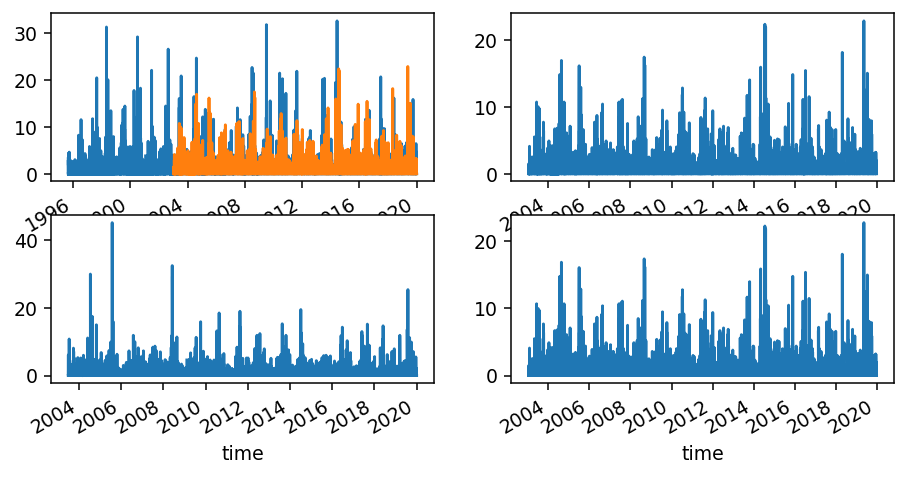

In [33]:
fig = plt.figure(dpi= 136, figsize=(8,4))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
df_merged_ts[1303].plot(ax = ax1)
df_merged_ts[2110].plot(ax = ax1)
df_merged_ts[2110].plot(ax = ax2)
df_merged_ts[1590].plot(ax = ax3)
df_merged_ts[2110].plot(ax = ax4)
plt.show()

In [33]:
df_merged_ts_transposed = df_merged_ts.transpose()

In [34]:
df_merged_ts_transposed.index.names = ['station_id']

In [35]:
df_merged_ts_transposed.shape

(83, 213225)

In [36]:
df_merged_ts_transposed.head()

time,1995-09-01 00:00:00,1995-09-01 01:00:00,1995-09-01 02:00:00,1995-09-01 03:00:00,1995-09-01 04:00:00,1995-09-01 05:00:00,1995-09-01 06:00:00,1995-09-01 07:00:00,1995-09-01 08:00:00,1995-09-01 09:00:00,...,2019-12-31 14:00:00,2019-12-31 15:00:00,2019-12-31 16:00:00,2019-12-31 17:00:00,2019-12-31 18:00:00,2019-12-31 19:00:00,2019-12-31 20:00:00,2019-12-31 21:00:00,2019-12-31 22:00:00,2019-12-31 23:00:00
station_id,,,,,,,,,,,,,,,,,,,,,
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
filepathname = local_ts_merged_dir + "prec_ts_merged_transposed.csv"
print("df_merged_ts_transposed is saved to: %s" % (filepathname))
df_merged_ts_transposed.to_csv(filepathname,sep=";")

df_merged_ts_transposed is saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_merged_transposed.csv


In [38]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
# TEMPERATURE                dftmp = temp_ts_to_df(myfile)
# PRECIPIATION
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [39]:
df_appended_ts = ts_append()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20191231_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20191231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20191231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20191231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_19950901_20191231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20191231_00554.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00603_19990303_20191002_hist.zip
Extract product file: produkt_rr_stunde_19990303_20191002_00603.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

In [40]:
df_appended_ts.shape

(11079774, 13)

In [56]:
df_appended_ts.head()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2004-10-01 00:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2021-02-22,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 01:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-02-22,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 02:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-02-22,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 03:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2021-02-22,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 04:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-02-22,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen


In [41]:
filepathname = local_ts_appended_dir + "prec_ts_appended.csv"
print("df_appended_ts saved to: %s" % (filepathname))
df_appended_ts.to_csv(filepathname,sep=";")

df_appended_ts saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_appended.csv


In [58]:
type(df_appended_ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [59]:
type(df_appended_ts.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [62]:
#df_appended_ts[["stations_id","r1","longitude", "latitude"]]

,stations_id,r1,longitude,latitude
mess_datum,,,,
2004-10-01 00:00:00,216,0.0,7.8807,51.1143
2004-10-01 01:00:00,216,0.0,7.8807,51.1143
2004-10-01 02:00:00,216,0.0,7.8807,51.1143
2004-10-01 03:00:00,216,0.0,7.8807,51.1143
2004-10-01 04:00:00,216,0.0,7.8807,51.1143
...,...,...,...,...
2019-12-31 19:00:00,15000,0.0,6.0244,50.7983
2019-12-31 20:00:00,15000,0.0,6.0244,50.7983
2019-12-31 21:00:00,15000,0.0,6.0244,50.7983


In [42]:
idx = (df_appended_ts.index >= '2017-04-16 00:00:00') & (df_appended_ts.index <= '2017-08-17 00:00:00')

In [43]:
df_appended_ts_4 = df_appended_ts[idx][["stations_id","r1","longitude", "latitude"]]
#df_appended_ts_june = df_appended_ts[idx][["stations_id","r1"]]

In [44]:
filepathname = local_ts_appended_dir + "prec_ts_appended_4.csv"
print("df_appended_ts_4 saved to: %s" % (filepathname))
df_appended_ts_4.to_csv(filepathname,sep=";")

df_appended_ts_4 saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_appended_4.csv


In [79]:
df_appended_ts_4[df_appended_ts_june["r1"] >= 0.2]

,stations_id,r1,longitude,latitude
mess_datum,,,,
2017-06-16 04:00:00,644,0.3,9.1738,51.7049
2017-06-16 11:00:00,644,0.2,9.1738,51.7049
2017-06-16 12:00:00,644,1.5,9.1738,51.7049
2017-06-16 11:00:00,2810,0.3,8.7749,51.9446
2017-06-16 11:00:00,3028,0.2,8.8388,51.7854
2017-06-16 05:00:00,3215,0.3,8.7125,51.1683
2017-06-16 13:00:00,4063,0.2,8.5906,52.4461
